In [1]:
## Provide a wider display for easier viewing
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
## Data Dictionary so that I can reference column names

## Field List	Description
## PNRLocatorID	PNR #. This could be treated as a confirmation number. Multiple flights and segments all roll up to one PNR #.
## TicketNum	Ticket Number - An itinerary may have multiple ticket numbers.
## CouponSeqNbr	Sabre assigned sequence number of the ticket coupon. Values are 1-16; values 5 and greater are a result of a conjunctive ticket.
## ServiceStartCity	Airport code for the city the flight is leaving from.
## ServiceEndCity	Airport code for the city the flight is landing at.
## PNRCreateDate	Date the ticket was booked
## ServiceStartDate	When the flight takes off
## PaxName	First 4 digits of the passenger last name and the first 2 digits of the passenger 1st name
## EncryptedName	Passenger name in encrypted format.
## GenderCode	M for Male and F for Female
## Birthdateid	A unique identifier that allows you to match birthdates across records without actually providing the birth date.
### Age	Age of the passenger at the time of the flight.
## PostalCode	Postal code of the location from where the booking was made.
## BkdClassOfService	What class of service (e.g. coach, first class, etc.) the passenger booked
## TrvldClassOfService	What class of service (e.g. coach, first class, etc.) the passenger travelled. This could be upgraded later in the flight.
## BookingChannel	How the passenger booked the flight. If this is showing a 3 letter code, it'smost likely booked at that airport. UFO is booked in Cancun.
## BaseFareAmt	Amount of the base fare (without taxes) of all segments on the ticket. Under certain circumstances such as bulk, net, award tickets, this value will be blank.
## TotalDocAmt	Total price of this ticket document including base fare, taxes and fees stated in the EquivBaseFareCurrCode. In the case of exchanges this amount may be zero or may only represent the difference in price from the previous ticket amount
## UflyRewardsNumber	The rewards number that was provided when booked.
## UflyMemberStatus	The Ufly member status. It will be either Standard or Elite.
## CardHolder	True or False value if the member is also a credit card holder.
## BookedProduct	Free form text field that is used to put discount codes in
## EnrollDate	When the member enrolled in Ufly rewards
## MarketingFlightNbr	Flight Number
## MarketingAirlineCode	The Airlines with which booking was made. We are only interested in â "SY" which is the code for Sun Country
## StopoverCode	O' for Layovers i.e. halt in a city for less than 24 hours.'X' for Stopovers that is halt in a city for more than 24 hours.

In [18]:
# Packages
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(cluster))
suppressPackageStartupMessages(library(Rtsne))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(sqldf))

In [2]:
## Read in small sample file
###suncountry <- data.frame(read.csv("SunCountry_nonr_sample.csv"))

## Only read in 7500 lines
suppressWarnings(suppressMessages(
df <- readr::read_csv(file = "C:/Users/monca016/Documents/Fall 2019/MSBA 6410 - Exploratory Analytics/HW2/SunCountry.csv", n_max = 7500)))

In [7]:
head(df)

PNRLocatorID,TicketNum,CouponSeqNbr,ServiceStartCity,ServiceEndCity,PNRCreateDate,ServiceStartDate,PaxName,EncryptedName,GenderCode,...,BaseFareAmt,TotalDocAmt,UFlyRewardsNumber,UflyMemberStatus,CardHolder,BookedProduct,EnrollDate,MarketingFlightNbr,MarketingAirlineCode,StopoverCode
AAABJK,3.377365e+12,2,JFK,MSP,2013-11-23,2013-12-13,BRUMSA,4252554D4241434B44696420493F7C20676574207468697320726967687453414E445241204C4545,F,...,234.20,0.0,NA,NA,NA,CHEOPQ,NA,244,SY,O
AAABJK,3.377365e+12,1,MSP,JFK,2013-11-23,2013-12-08,BRUMSA,4252554D4241434B44696420493F7C20676574207468697320726967687453414E445241204C4545,F,...,234.20,0.0,NA,NA,NA,CHEOPQ,NA,243,SY,NA
AAABMK,3.372107e+12,2,MSP,SFO,2014-02-04,2014-02-23,EILDRY,45494C4445525344696420493F7C2067657420746869732072696768745259414E204C,M,...,293.96,338.0,NA,NA,NA,NA,NA,397,SY,O
AAABMK,3.372107e+12,1,SFO,MSP,2014-02-04,2014-02-20,EILDRY,45494C4445525344696420493F7C2067657420746869732072696768745259414E204C,M,...,293.96,338.0,NA,NA,NA,NA,NA,392,SY,NA
AAABTP,3.372107e+12,1,MCO,MSP,2014-03-13,2014-04-23,SKELMA,534B454C544F4E44696420493F7C2067657420746869732072696768744D4152534841,F,...,112.56,132.0,NA,NA,NA,NA,NA,342,SY,NA
AAACLY,3.372106e+12,1,PSP,MSP,2012-10-06,2013-02-12,HINZRI,48494E5A4544696420493F7C206765742074686973207269676874524943484152442043,M,...,171.16,194.8,NA,NA,NA,NA,NA,610,SY,NA


In [8]:
## Chain Trip Points

a <- df %>% 
select(PNRLocatorID, TicketNum, CouponSeqNbr, ServiceStartCity, ServiceEndCity) %>% 
group_by(TicketNum) %>% 
mutate(trip_max = max(CouponSeqNbr))

a1 <- a %>% filter(CouponSeqNbr == 1) %>% 
select(PNRLocatorID, TicketNum, ServiceStartCity, ServiceEndCity, trip_max) %>% 
rename(City1 = ServiceStartCity, City2 = ServiceEndCity)

a2 <- a %>% filter(CouponSeqNbr == 2) %>% 
select(PNRLocatorID, TicketNum, ServiceEndCity, trip_max) %>% 
rename(City3 = ServiceEndCity)

a3 <- a %>% filter(CouponSeqNbr == 3) %>% 
select(PNRLocatorID, TicketNum, ServiceEndCity, trip_max) %>% 
rename(City4 = ServiceEndCity)

a4 <- a %>% filter(CouponSeqNbr == 4) %>% 
select(PNRLocatorID, TicketNum, ServiceEndCity, trip_max) %>% 
rename(City5 = ServiceEndCity)

a5 <- a %>% filter(CouponSeqNbr == 5) %>% 
select(PNRLocatorID, TicketNum, ServiceEndCity, trip_max) %>% 
rename(City6 = ServiceEndCity)

a6 <- a %>% filter(CouponSeqNbr == 6) %>% 
select(PNRLocatorID, TicketNum, ServiceEndCity, trip_max) %>% 
rename(City7 = ServiceEndCity)

jc <- c("trip_max" = "trip_max", "PNRLocatorID"="PNRLocatorID", 
        "TicketNum"="TicketNum")

j1 <- left_join(a1, a2, by=jc)
j2 <- left_join(j1, a3, by=jc)
j3 <- left_join(j2, a4, by=jc)
j4 <- left_join(j3, a5, by=jc)
j5 <- left_join(j4, a6, by=jc) %>% 
  select(PNRLocatorID, TicketNum, trip_max, 
         City1, City2, City3, City4, City5, City6, City7)

In [9]:
head(df)

PNRLocatorID,TicketNum,CouponSeqNbr,ServiceStartCity,ServiceEndCity,PNRCreateDate,ServiceStartDate,PaxName,EncryptedName,GenderCode,...,BaseFareAmt,TotalDocAmt,UFlyRewardsNumber,UflyMemberStatus,CardHolder,BookedProduct,EnrollDate,MarketingFlightNbr,MarketingAirlineCode,StopoverCode
AAABJK,3.377365e+12,2,JFK,MSP,2013-11-23,2013-12-13,BRUMSA,4252554D4241434B44696420493F7C20676574207468697320726967687453414E445241204C4545,F,...,234.20,0.0,NA,NA,NA,CHEOPQ,NA,244,SY,O
AAABJK,3.377365e+12,1,MSP,JFK,2013-11-23,2013-12-08,BRUMSA,4252554D4241434B44696420493F7C20676574207468697320726967687453414E445241204C4545,F,...,234.20,0.0,NA,NA,NA,CHEOPQ,NA,243,SY,NA
AAABMK,3.372107e+12,2,MSP,SFO,2014-02-04,2014-02-23,EILDRY,45494C4445525344696420493F7C2067657420746869732072696768745259414E204C,M,...,293.96,338.0,NA,NA,NA,NA,NA,397,SY,O
AAABMK,3.372107e+12,1,SFO,MSP,2014-02-04,2014-02-20,EILDRY,45494C4445525344696420493F7C2067657420746869732072696768745259414E204C,M,...,293.96,338.0,NA,NA,NA,NA,NA,392,SY,NA
AAABTP,3.372107e+12,1,MCO,MSP,2014-03-13,2014-04-23,SKELMA,534B454C544F4E44696420493F7C2067657420746869732072696768744D4152534841,F,...,112.56,132.0,NA,NA,NA,NA,NA,342,SY,NA
AAACLY,3.372106e+12,1,PSP,MSP,2012-10-06,2013-02-12,HINZRI,48494E5A4544696420493F7C206765742074686973207269676874524943484152442043,M,...,171.16,194.8,NA,NA,NA,NA,NA,610,SY,NA


In [13]:
## Get counts 
count(df, var = UflyMemberStatus)

var,n
Elite,34
Standard,1445
NA,6021


In [14]:
count(df, var = CardHolder)

var,n
FALSE,1423
TRUE,56
NA,6021


In [17]:
## Any UFlyRewardsNumber that are NULL should be excluded, it means they didn't book with UFlyRewards
head(count(df, var = UFlyRewardsNumber), 5)

var,n
100013561,2
100022370,2
100042235,1
100082415,1
100153056,2


In [3]:
flight_legs <- function(dataframe_in) {
  
  a <- dataframe_in %>% 
  select(PNRLocatorID, TicketNum, CouponSeqNbr, ServiceStartCity, ServiceEndCity) %>% 
  group_by(TicketNum) %>% mutate(trip_max = max(CouponSeqNbr))

  a1 <- a %>% filter(CouponSeqNbr == 1) %>% 
    select(PNRLocatorID, TicketNum, ServiceStartCity, ServiceEndCity, trip_max) %>% 
    rename(City1 = ServiceStartCity, City2 = ServiceEndCity)
  
  a2 <- a %>% filter(CouponSeqNbr == 2) %>% 
    select(PNRLocatorID, TicketNum, ServiceEndCity, trip_max) %>% 
    rename(City3 = ServiceEndCity)
  
  a3 <- a %>% filter(CouponSeqNbr == 3) %>% 
    select(PNRLocatorID, TicketNum, ServiceEndCity, trip_max) %>% 
    rename(City4 = ServiceEndCity)
  
  a4 <- a %>% filter(CouponSeqNbr == 4) %>% 
    select(PNRLocatorID, TicketNum, ServiceEndCity, trip_max) %>% 
    rename(City5 = ServiceEndCity)
  
  a5 <- a %>% filter(CouponSeqNbr == 5) %>% 
    select(PNRLocatorID, TicketNum, ServiceEndCity, trip_max) %>% 
    rename(City6 = ServiceEndCity)
  
  a6 <- a %>% filter(CouponSeqNbr == 6) %>% 
    select(PNRLocatorID, TicketNum, ServiceEndCity, trip_max) %>% 
    rename(City7 = ServiceEndCity)
  
  j1 <- left_join(a1, a2, by=c("trip_max" = "trip_max", "PNRLocatorID"="PNRLocatorID", 
                               "TicketNum"="TicketNum"))
  j2 <- left_join(j1, a3, by=c("trip_max" = "trip_max", "PNRLocatorID"="PNRLocatorID", 
                               "TicketNum"="TicketNum"))
  j3 <- left_join(j2, a4, by=c("trip_max" = "trip_max", "PNRLocatorID"="PNRLocatorID", 
                               "TicketNum"="TicketNum"))
  j4 <- left_join(j3, a5, by=c("trip_max" = "trip_max", "PNRLocatorID"="PNRLocatorID", 
                               "TicketNum"="TicketNum"))
  j5 <- left_join(j4, a6, by=c("trip_max" = "trip_max", "PNRLocatorID"="PNRLocatorID", 
                               "TicketNum"="TicketNum")) %>% 
    select(PNRLocatorID, TicketNum, trip_max, City1, City2, City3, City4, City5, 
           City6, City7)
  
  jx <- as_tibble(j5) %>% unite("Airport_Seqence", City1:City7, sep = "->", na.rm = TRUE)
  jx <- jx[!duplicated(jx),]
  
  return(jx)
}

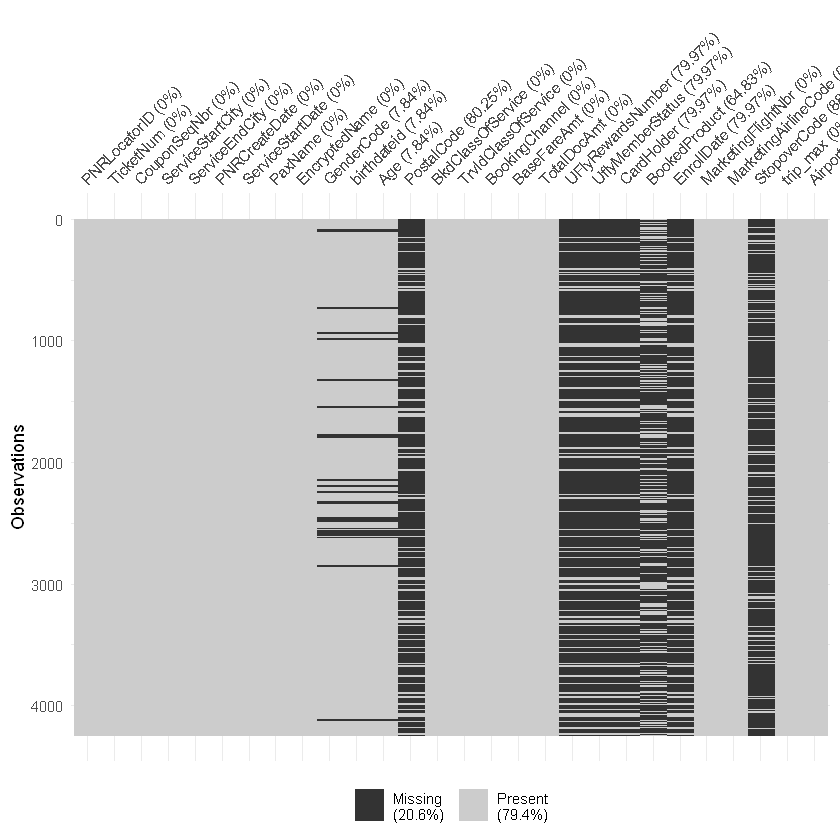

In [4]:
# Filtering Data 
df_msp <- df %>% filter(CouponSeqNbr == 1) 
df_msp_start <- left_join(df_msp, flight_legs(df), by = c("PNRLocatorID", "TicketNum")) 

naniar::vis_miss(df_msp_start)

In [5]:
head(df_msp_start)

PNRLocatorID,TicketNum,CouponSeqNbr,ServiceStartCity,ServiceEndCity,PNRCreateDate,ServiceStartDate,PaxName,EncryptedName,GenderCode,...,UFlyRewardsNumber,UflyMemberStatus,CardHolder,BookedProduct,EnrollDate,MarketingFlightNbr,MarketingAirlineCode,StopoverCode,trip_max,Airport_Seqence
AAABJK,3.377365e+12,1,MSP,JFK,2013-11-23,2013-12-08,BRUMSA,4252554D4241434B44696420493F7C20676574207468697320726967687453414E445241204C4545,F,...,NA,NA,NA,CHEOPQ,NA,243,SY,NA,2,MSP->JFK->MSP
AAABMK,3.372107e+12,1,SFO,MSP,2014-02-04,2014-02-20,EILDRY,45494C4445525344696420493F7C2067657420746869732072696768745259414E204C,M,...,NA,NA,NA,NA,NA,392,SY,NA,2,SFO->MSP->SFO
AAABTP,3.372107e+12,1,MCO,MSP,2014-03-13,2014-04-23,SKELMA,534B454C544F4E44696420493F7C2067657420746869732072696768744D4152534841,F,...,NA,NA,NA,NA,NA,342,SY,NA,1,MCO->MSP
AAACLY,3.372106e+12,1,PSP,MSP,2012-10-06,2013-02-12,HINZRI,48494E5A4544696420493F7C206765742074686973207269676874524943484152442043,M,...,NA,NA,NA,NA,NA,610,SY,NA,1,PSP->MSP
AAACWU,3.372108e+12,1,JFK,MSP,2014-10-21,2014-11-14,GIBAJU,47494241534A4F4E455344696420493F7C2067657420746869732072696768744A554C4941,F,...,NA,NA,NA,SSWMIR,NA,244,SY,NA,1,JFK->MSP
AAACWU,3.372108e+12,1,JFK,MSP,2014-10-21,2014-11-14,GIBAAL,474942415344696420493F7C206765742074686973207269676874414C4C454E,M,...,NA,NA,NA,SSWMIR,NA,244,SY,NA,1,JFK->MSP


In [11]:
df_msp_start %>% drop_na()

PNRLocatorID,TicketNum,CouponSeqNbr,ServiceStartCity,ServiceEndCity,PNRCreateDate,ServiceStartDate,PaxName,EncryptedName,GenderCode,...,UFlyRewardsNumber,UflyMemberStatus,CardHolder,BookedProduct,EnrollDate,MarketingFlightNbr,MarketingAirlineCode,StopoverCode,trip_max,Airport_Seqence
AAWDNN,3.377414e+12,1,LAX,MSP,2014-09-24,2014-09-25,LARSJA,4C4152534F4E44696420493F7C2067657420746869732072696768744A41534F4E2044,M,...,201639023,Standard,FALSE,NFI,2008-04-14 09:19:49,0422,SY,O,1,LAX->MSP
ABEXJA,3.377350e+12,1,DFW,MSP,2013-10-29,2013-11-16,REBAJE,52454241524348454B44696420493F7C2067657420746869732072696768744A45414E4E45,F,...,210045916,Standard,FALSE,ONEOPQ,2013-01-29 17:03:18,504,SY,O,1,DFW->MSP
AAVMWE,3.377542e+12,1,MSP,BOS,2014-11-17,2014-11-18,PETHVI,504554484544696420493F7C20676574207468697320726967687456495348574153205659414E4B415452414F,M,...,211121330,Standard,FALSE,CWT971,2014-09-07 11:08:19,0253,SY,O,2,MSP->BOS->MSP
ABDZAA,3.377349e+12,1,MSP,BOS,2014-04-08,2014-04-28,RHOAMI,52484F41445344696420493F7C2067657420746869732072696768744D49544348454C4C204C,M,...,203304032,Standard,FALSE,ANDER,2012-07-07 22:28:58,0251,SY,O,1,MSP->BOS


In [12]:
DF <- data.frame(x = c(1, 2, 3), y = c(0, 10, NA), z=c(NA, 33, 22))

completeFun <- function(data, desiredCols) {
  completeVec <- complete.cases(data[, desiredCols])
  return(data[completeVec, ])
}

In [13]:
completeFun(DF, "y")

x,y,z
1,0,NA
2,10,33


In [15]:
## Drop all rows that don't have a UFlyRewardsMembership number so I can just analyze this group
uflymembers_only <- completeFun(df_msp_start, "UFlyRewardsNumber")

In [16]:
summary(uflymembers_only)

 PNRLocatorID         TicketNum          CouponSeqNbr ServiceStartCity  
 Length:851         Min.   :3.372e+12   Min.   :1     Length:851        
 Class :character   1st Qu.:3.372e+12   1st Qu.:1     Class :character  
 Mode  :character   Median :3.372e+12   Median :1     Mode  :character  
                    Mean   :3.373e+12   Mean   :1                       
                    3rd Qu.:3.372e+12   3rd Qu.:1                       
                    Max.   :3.378e+12   Max.   :1                       
                                                                        
 ServiceEndCity     PNRCreateDate        ServiceStartDate    
 Length:851         Min.   :2012-10-02   Min.   :2013-01-04  
 Class :character   1st Qu.:2013-05-29   1st Qu.:2013-07-19  
 Mode  :character   Median :2013-11-16   Median :2014-01-23  
                    Mean   :2013-11-23   Mean   :2014-01-21  
                    3rd Qu.:2014-05-24   3rd Qu.:2014-07-24  
                    Max.   :2014-12-21   Max

In [ ]:
## Group by year >= 2016, get max price, min price, average price
## number of flights
## number of passengers
## de-dupe on encrypted name + gender